# Monitor 日志分析 (memory + timings)

该 notebook 读取 `monitor_profiles/runtime_metrics.log` 和 `monitor_profiles/timings.log`（或通过环境变量 `TRACEMALLOC_SNAPSHOT_DIR` 指定目录），并绘制内存随时间的变化以及各个采样点的耗时分布。

In [11]:
# 指定日志目录（可交互输入），留空使用默认监测目录 monitor_profiles/ 或环境变量 TRACEMALLOC_SNAPSHOT_DIR
import os
from pathlib import Path
user_dir = input('输入日志目录路径（回车使用默认 monitor_profiles/ 或 TRACEMALLOC_SNAPSHOT_DIR）: ').strip()
if user_dir:
    profile_dir = Path(user_dir)
else:
    env_dir = os.environ.get('TRACEMALLOC_SNAPSHOT_DIR', '')
    profile_dir = Path(env_dir) if env_dir else Path('.') / 'monitor_profiles'
print('使用日志目录 ->', profile_dir)

使用日志目录 -> D:\carbon_tracemalloc_snapshots


In [15]:
import os, json, math, statistics
from pathlib import Path
import datetime

# plotting libs
try:
    import matplotlib.pyplot as plt
    CAN_PLOT = True
except Exception:
    CAN_PLOT = False
    plt = None
try:
    import numpy as np
except Exception:
    np = None

# locate profile dir: prefer previously-set `profile_dir` (from first cell),
# otherwise fall back to TRACEMALLOC_SNAPSHOT_DIR or ./monitor_profiles
try:
    profile_dir
except NameError:
    profile_dir = Path(os.environ.get('TRACEMALLOC_SNAPSHOT_DIR', ''))
    if not profile_dir or not profile_dir.exists():
        profile_dir = Path('.') / 'monitor_profiles'
else:
    # ensure it's a Path and if missing, try env/default
    if isinstance(profile_dir, str):
        profile_dir = Path(profile_dir)
    if not profile_dir.exists():
        env_dir = os.environ.get('TRACEMALLOC_SNAPSHOT_DIR', '')
        profile_dir = Path(env_dir) if env_dir else Path('.') / 'monitor_profiles'

runtime_path = profile_dir / 'runtime_metrics.log'
timings_path = profile_dir / 'timings.log'

print('profile_dir ->', str(profile_dir))
print('runtime_metrics exists:', runtime_path.exists())
print('timings exists:', timings_path.exists())

# helpers to read json-lines
def read_json_lines(path):
    data = []
    if not path.exists():
        return data
    with open(path, 'r', encoding='utf-8') as f:
        for ln in f:
            ln = ln.strip()
            if not ln:
                continue
            try:
                data.append(json.loads(ln))
            except Exception as e:
                # skip malformed lines
                continue
    return data

runtime_data = read_json_lines(runtime_path)
timings_data = read_json_lines(timings_path)

print(f'Loaded runtime samples: {len(runtime_data)}, timing samples: {len(timings_data)}')

profile_dir -> D:\carbon_tracemalloc_snapshots
runtime_metrics exists: True
timings exists: True
Loaded runtime samples: 35, timing samples: 172


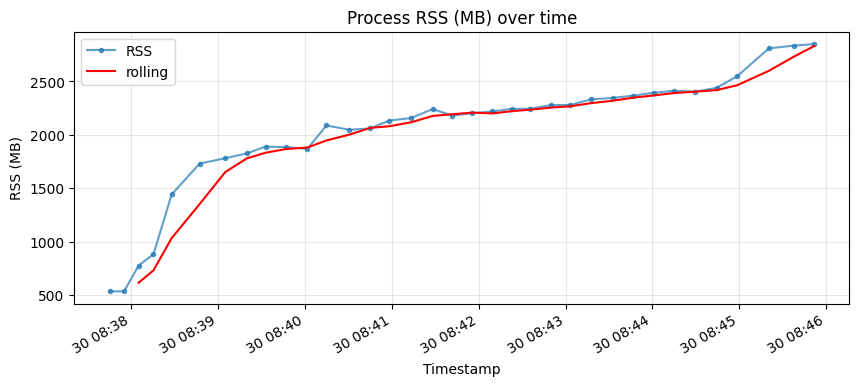

In [16]:
# Memory over time plot (RSS in MB)
if len(runtime_data) == 0:
    print('No runtime metrics to plot.')
else:
    times = []
    rss_mb = []
    for item in runtime_data:
        try:
            t = item.get('ts')
            if t:
                # parse ISO timestamp if present
                times.append(datetime.datetime.fromisoformat(t.replace('Z', '+00:00')))
            mem = item.get('mem') or {}
            rss = mem.get('rss')
            if rss is None:
                rss = item.get('rss') or 0
            rss_mb.append((rss or 0) / (1024.0 * 1024.0))
        except Exception:
            continue

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(times, rss_mb, marker='.', linestyle='-', alpha=0.7, label='RSS')
    # rolling mean if numpy available
    try:
        if np is not None and len(rss_mb) >= 3:
            window = max(3, int(len(rss_mb)/20))
            from collections import deque
            arr = np.array(rss_mb)
            s = np.convolve(arr, np.ones(window)/window, mode='valid')
            ax.plot(times[window-1:], s, color='red', linewidth=1.5, label='rolling')
    except Exception:
        pass

    # show legend for lines
    try:
        ax.legend(loc='upper left')
    except Exception:
        pass

    ax.set_title('Process RSS (MB) over time')
    ax.set_ylabel('RSS (MB)')
    ax.set_xlabel('Timestamp')
    fig.autofmt_xdate()
    ax.grid(True, alpha=0.3)
    plt.show()

--- Summary ---
Found 7 tracemalloc snapshots due to RSS growth

Last snapshot:
  ts: 2026-01-30T08:45:20.468459Z
  rss (bytes): 2945355776
  delta (bytes): 273108992
  pct increase: 0.10220200979761007

Top allocation frames (last snapshot):
  1. size=49605556 bytes count=299719
      <frozen importlib._bootstrap_external>:757
  2. size=2558976 bytes count=45696
      C:\Users\24540\AppData\Local\Programs\Python\Python312\Lib\tracemalloc.py:505
  3. size=2193408 bytes count=45696
      C:\Users\24540\AppData\Local\Programs\Python\Python312\Lib\tracemalloc.py:498
  4. size=2097744 bytes count=43703
      C:\Users\24540\AppData\Local\Programs\Python\Python312\Lib\tracemalloc.py:193
  5. size=1972030 bytes count=17436
      C:\Users\24540\AppData\Local\Programs\Python\Python312\Lib\dataclasses.py:473
  6. size=706501 bytes count=7169
      C:\Users\24540\AppData\Local\Programs\Python\Python312\Lib\linecache.py:142
  7. size=657240 bytes count=137
      C:\Users\24540\AppData\Local\Carbon

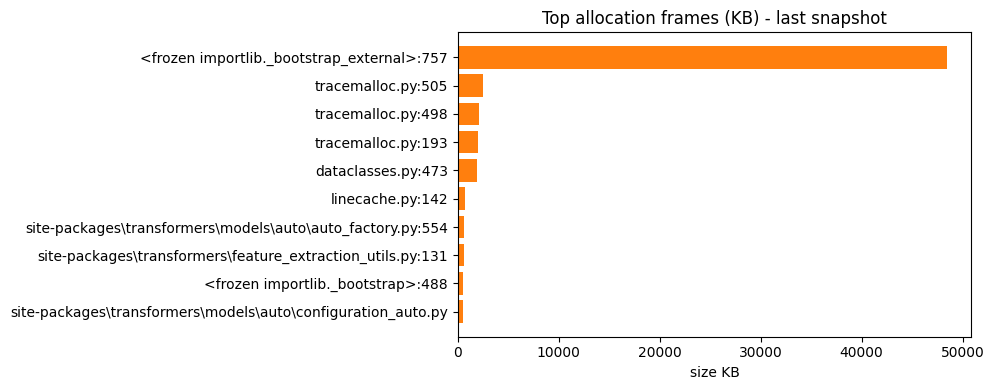


Top RSS samples (time, bytes):
2026-01-30T08:45:51.784655Z 2987601920 bytes (2849.2 MB)
2026-01-30T08:45:37.692400Z 2972565504 bytes (2834.9 MB)
2026-01-30T08:45:20.468459Z 2945355776 bytes (2808.9 MB)
2026-01-30T08:44:58.618993Z 2672246784 bytes (2548.5 MB)
2026-01-30T08:44:44.314516Z 2558017536 bytes (2439.5 MB)
2026-01-30T08:44:15.035052Z 2528526336 bytes (2411.4 MB)
2026-01-30T08:44:29.588956Z 2521407488 bytes (2404.6 MB)
2026-01-30T08:44:01.434004Z 2511093760 bytes (2394.8 MB)
2026-01-30T08:43:46.947510Z 2482118656 bytes (2367.1 MB)
2026-01-30T08:43:32.720008Z 2459541504 bytes (2345.6 MB)

Top timing blocks (name, count, avg_s):
('worker.ocr_recognize', 39, 4.449258676922629)
('worker.add_image', 39, 3.430864489743283)
('ocr.recognize', 39, 1.9148481205189363)
('clip.encode_image', 39, 0.5110238974358743)


In [21]:
# Quick summaries and snapshot inspection
print('--- Summary ---')

# Show tracing snapshots triggered by RSS growth
snapshots_path = profile_dir / 'tracemalloc_snapshots.log'
if snapshots_path.exists():
    snaps = []
    with open(snapshots_path, 'r', encoding='utf-8') as f:
        for ln in f:
            try:
                snaps.append(json.loads(ln))
            except Exception:
                continue
    print(f'Found {len(snaps)} tracemalloc snapshots due to RSS growth')
    if snaps:
        # show last snapshot summary
        last = snaps[-1]
        print('\nLast snapshot:')
        print('  ts:', last.get('ts'))
        print('  rss (bytes):', last.get('rss'))
        print('  delta (bytes):', last.get('delta'))
        print('  pct increase:', last.get('pct'))
        top = last.get('top') or []
        if top:
            print('\nTop allocation frames (last snapshot):')
            for i, it in enumerate(top[:10]):
                print(f"  {i+1}. size={it.get('size')} bytes count={it.get('count')}")
                tb = it.get('traceback')
                # print first line of traceback for brevity
                if tb:
                    first_line = str(tb).splitlines()[0]
                    print('     ', first_line)
        # if matplotlib available, draw bar chart of top sizes
        if 'top' in last and last.get('top') and CAN_PLOT:
            labels = []
            sizes = []
            for it in last.get('top')[:10]:
                tb = it.get('traceback') or ''
                label = tb.splitlines()[0] if tb else ''
                # 如果包含 Windows 库路径 '\\Lib'，保留其之后的部分以避免纵轴太长
                if '\\Lib' in label:
                    try:
                        parts = label.split('\\Lib', 1)
                        label = parts[1] if len(parts) > 1 else parts[-1]
                        label = label.lstrip('\\/ ').strip()
                    except Exception:
                        pass
                labels.append(label[:60])
                sizes.append(it.get('size')/1024.0)
            fig, ax = plt.subplots(figsize=(10,4))
            ax.barh(labels[::-1], sizes[::-1], color='C1')
            ax.set_xlabel('size KB')
            ax.set_title('Top allocation frames (KB) - last snapshot')
            plt.tight_layout()
            plt.show()
else:
    print('No tracemalloc snapshot log found at', snapshots_path)

# existing runtime summary
if runtime_data:
    # top RSS samples
    rss_list = []
    for item in runtime_data:
        mem = item.get('mem') or {}
        rss = mem.get('rss') or 0
        rss_list.append((item.get('ts'), rss))
    rss_sorted = sorted(rss_list, key=lambda x: x[1], reverse=True)[:10]
    print('\nTop RSS samples (time, bytes):')
    for t, v in rss_sorted:
        print(t, int(v), 'bytes', f'({v/1024/1024:.1f} MB)')
else:
    print('No runtime metrics')

if timings_data:
    stats_sorted = sorted([(k, len(v), statistics.mean(v)) for k, v in groups.items()], key=lambda x: x[2], reverse=True)[:10]
    print('\nTop timing blocks (name, count, avg_s):')
    for row in stats_sorted:
        print(row)
else:
    print('No timing metrics')

In [22]:
# Quick summaries
print('--- Summary ---')
if runtime_data:
    # top RSS samples
    rss_list = []
    for item in runtime_data:
        mem = item.get('mem') or {}
        rss = mem.get('rss') or 0
        rss_list.append((item.get('ts'), rss))
    rss_sorted = sorted(rss_list, key=lambda x: x[1], reverse=True)[:10]
    print('Top RSS samples (time, bytes):')
    for t, v in rss_sorted:
        print(t, int(v), 'bytes', f'({v/1024/1024:.1f} MB)')
else:
    print('No runtime metrics')

if timings_data:
    stats_sorted = sorted([(k, len(v), statistics.mean(v)) for k, v in groups.items()], key=lambda x: x[2], reverse=True)[:10]
    print('Top timing blocks (name, count, avg_s):')
    for row in stats_sorted:
        print(row)
else:
    print('No timing metrics')

--- Summary ---
Top RSS samples (time, bytes):
2026-01-30T08:45:51.784655Z 2987601920 bytes (2849.2 MB)
2026-01-30T08:45:37.692400Z 2972565504 bytes (2834.9 MB)
2026-01-30T08:45:20.468459Z 2945355776 bytes (2808.9 MB)
2026-01-30T08:44:58.618993Z 2672246784 bytes (2548.5 MB)
2026-01-30T08:44:44.314516Z 2558017536 bytes (2439.5 MB)
2026-01-30T08:44:15.035052Z 2528526336 bytes (2411.4 MB)
2026-01-30T08:44:29.588956Z 2521407488 bytes (2404.6 MB)
2026-01-30T08:44:01.434004Z 2511093760 bytes (2394.8 MB)
2026-01-30T08:43:46.947510Z 2482118656 bytes (2367.1 MB)
2026-01-30T08:43:32.720008Z 2459541504 bytes (2345.6 MB)
Top timing blocks (name, count, avg_s):
('worker.ocr_recognize', 39, 4.449258676922629)
('worker.add_image', 39, 3.430864489743283)
('ocr.recognize', 39, 1.9148481205189363)
('clip.encode_image', 39, 0.5110238974358743)


## 使用说明
- 若缺少依赖，请安装 `matplotlib`（和可选的 `numpy`）。
- 可通过设置环境变量 `TRACEMALLOC_SNAPSHOT_DIR` 指定日志目录，或将日志放到仓库根的 `monitor_profiles/` 下。
- 运行本 notebook 后，检查 `monitor_profiles/` 中生成的 `timings.log` 和 `runtime_metrics.log` 来定位热点。